## Sharding Penalty Algorithm Implemented Within a Dummy Network

This code is based on an original implementation by Naseem Alsadi, which focused on optimizing the number 
of shards with a specific penalty. I have adapted and extended the code to address a more specific scenario: 
optimizing sharding in a network with Byzantine nodes while balancing clustering quality and security risks.

Original concept and base implementation: Naseem Alsadi  
Adaptations and extensions by: Ahmad Kanoun.


Number of Byzantine nodes: 100.0
Optimal number of shards without penalty: 20
Optimal number of shards with penalty: 7


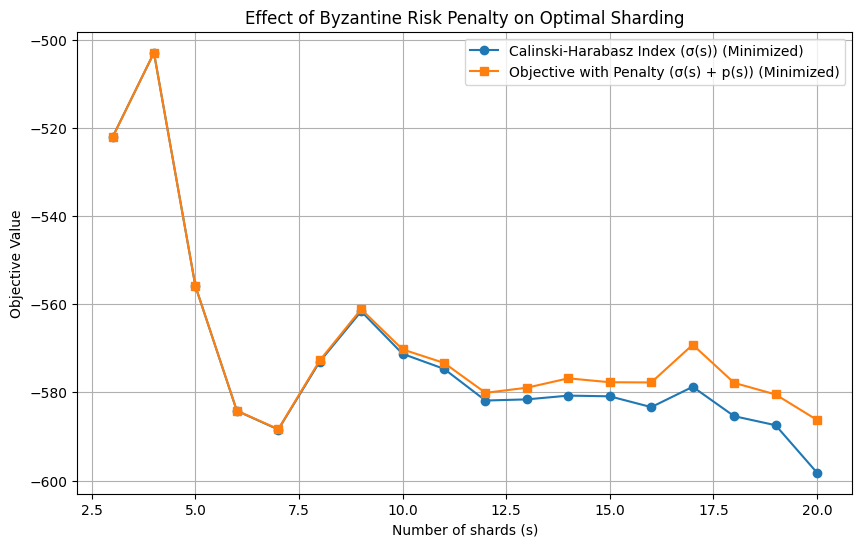

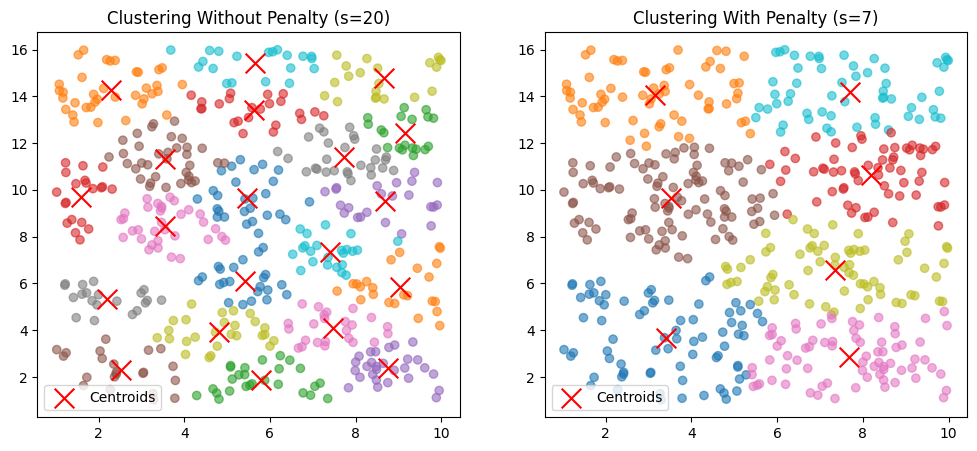

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from scipy.special import comb
from scipy.stats import hypergeom
from dummy_network import DummyNetwork, DummyNode


"""
This code is based on an original implementation by Naseem Alsadi, which focused on optimizing the number 
of shards with a specific penalty. I have adapted and extended the code to address a more specific scenario: 
optimizing sharding in a network with Byzantine nodes while balancing clustering quality and security risks.

Original concept and base implementation: Naseem Alsadi  
Adaptations and extensions by: Ahmad Kanoun.
"""
# ----- Parameters -----
N = 500  # Total number of nodes
s_min = 3
s_max = 20
lambda_val = 0.4  # Penalty weight
byzantine_threshold = 0.3  # Fraction of malicious nodes needed for a majority

# Generate dummy nodes with random attributes
random.seed(42)
nodes = [
    DummyNode(
        node_id=i,
        cpu_rating=random.uniform(1, 10),  # Random CPU rating
        reputation_score=random.uniform(0, 1),  # Random reputation score
        ram_usage=random.uniform(1, 16)  # Random RAM usage
    )
    for i in range(N)]

# Identify Byzantine nodes (low reputation score)
K_malicious = N * 0.2
print(f"Number of Byzantine nodes: {K_malicious}")

# Create a network with the nodes
network = DummyNetwork(nodes)

# Extract features for clustering (e.g., CPU rating and RAM usage)
Z = np.array([[node.cpu_rating, node.ram_usage] for node in network.validator_nodes])

# ----- Function to Compute Calinski-Harabasz Index -----
def compute_ch_index(Z, labels, s):
    return -calinski_harabasz_score(Z, labels) if s > 1 else 0  # Minimize

# ----- Compute Byzantine Risk Probability -----
def compute_byzantine_risk(s):
    shard_size = int(np.ceil(N / s))  # Account for variable shard sizes
    threshold = int(np.ceil(shard_size * byzantine_threshold))
    
    # Use hypergeometric survival function for P(X >= threshold)
    risk = hypergeom.sf(threshold - 1, N, K_malicious, shard_size)
    return risk

# ----- Main Simulation -----
s_values = np.arange(s_min, s_max + 1)
ch_scores = []
penalized_scores = []
byzantine_risks = []
best_kmeans_no_penalty = None
best_kmeans_penalty = None
best_labels_no_penalty = None
best_labels_penalty = None

for s in s_values:
    # Apply K-Means clustering for sharding
    kmeans = KMeans(n_clusters=s, random_state=42, n_init=10)
    labels = kmeans.fit_predict(Z)

    # Compute Calinski-Harabasz index (Minimization)
    ch_index = compute_ch_index(Z, labels, s)
    ch_scores.append(ch_index)

    # Compute Byzantine risk penalty with dynamic shard size
    byzantine_risk = compute_byzantine_risk(s)
    penalty = lambda_val * byzantine_risk * (s - s_min) ** 2
    penalized_score = ch_index + penalty  # Minimize objective

    # Store results
    byzantine_risks.append(byzantine_risk)
    penalized_scores.append(penalized_score)

    # Store best clustering results
    if s == s_values[np.argmin(ch_scores)]:  # Best without penalty
        best_kmeans_no_penalty = kmeans
        best_labels_no_penalty = labels

    if s == s_values[np.argmin(penalized_scores)]:  # Best with penalty
        best_kmeans_penalty = kmeans
        best_labels_penalty = labels

# ----- Find Optimal Sharding Values -----
opt_s_no_penalty = s_values[np.argmin(ch_scores)]
opt_s_penalty = s_values[np.argmin(penalized_scores)]

print(f"Optimal number of shards without penalty: {opt_s_no_penalty}")
print(f"Optimal number of shards with penalty: {opt_s_penalty}")

# ----- Plot Results -----
plt.figure(figsize=(10, 6))
plt.plot(s_values, ch_scores, 'o-', label="Calinski-Harabasz Index (σ(s)) (Minimized)")
plt.plot(s_values, penalized_scores, 's-', label="Objective with Penalty (σ(s) + p(s)) (Minimized)")
plt.xlabel("Number of shards (s)")
plt.ylabel("Objective Value")
plt.title("Effect of Byzantine Risk Penalty on Optimal Sharding")
plt.legend()
plt.grid(True)
plt.show()

# ----- Visualizing Clustering Results -----
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Without penalty
axs[0].scatter(Z[:, 0], Z[:, 1], c=best_labels_no_penalty, cmap="tab10", alpha=0.6)
axs[0].scatter(best_kmeans_no_penalty.cluster_centers_[:, 0], best_kmeans_no_penalty.cluster_centers_[:, 1], c='red', marker='x', s=200, label="Centroids")
axs[0].set_title(f"Clustering Without Penalty (s={opt_s_no_penalty})")
axs[0].legend()

# With penalty
axs[1].scatter(Z[:, 0], Z[:, 1], c=best_labels_penalty, cmap="tab10", alpha=0.6)
axs[1].scatter(best_kmeans_penalty.cluster_centers_[:, 0], best_kmeans_penalty.cluster_centers_[:, 1], c='red', marker='x', s=200, label="Centroids")
axs[1].set_title(f"Clustering With Penalty (s={opt_s_penalty})")
axs[1].legend()

plt.show()